<a href="https://colab.research.google.com/github/mohith939/Commodity-Pricing-Model/blob/main/Commodity_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 1. Schwartz One-Factor Model (1997)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class SchwartzOneFactor:
    def __init__(self, S0: float, kappa: float, mu: float, sigma: float, T: float, n_steps: int, r: float = 0.0):
        self.S0 = S0
        self.kappa = kappa
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.r = r

    """
    Parameters:
    S0 : Initial spot price.
    kappa : Mean-reversion speed.
    mu : Long-term mean of log-price.
    sigma : Volatility.
    T : Time horizon.
    n_steps : Number of time steps.
    r : Risk-free rate for discounting (default 0, if not pricing a derivative).
    Price Definition:
    The model assumes:
    d(ln S_t) = kappa (mu - ln S_t) dt + sigma dW_t,
    and hence S_t = exp(X_t) with X_t = ln S_t.
    """

    def simulate_paths(self, n_paths: int = 100) -> np.ndarray:
        """
        Simulate commodity price paths using the Schwartz One-Factor model.
        Returns:
        paths: A (n_steps+1) x n_paths array representing S_t.
        """
        paths = np.zeros((self.n_steps + 1, n_paths))
        # Work in log-space
        logS = np.log(self.S0) * np.ones(n_paths)
        paths[0, :] = self.S0
        for t in range(1, self.n_steps + 1):
            Z = np.random.randn(n_paths)
            dlogS = self.kappa * (self.mu - logS) * self.dt + self.sigma * np.sqrt(self.dt) * Z
            logS += dlogS
            paths[t, :] = np.exp(logS)
        return paths

    def calculate_price(self, paths: np.ndarray) -> float:
        """
        Calculate the commodity price as the mean of the simulated paths at maturity.
        If desired, discount the mean price back to time 0.
        """
        final_prices = paths[-1, :]
        mean_price = np.mean(final_prices)
        # Discount if a risk-free rate is provided
        return np.exp(-self.r * self.T) * mean_price

    def calibrate(self, observed_logS: np.ndarray, times: np.ndarray):
        """
        Calibrate parameters (kappa, mu, sigma) using observed log-prices.
        """
        def objective(params):
            kappa, mu, sigma = params
            logS_model = np.log(self.S0)
            error = 0.0
            for i in range(1, len(times)):
                dt = times[i] - times[i - 1]
                logS_model = logS_model + kappa * (mu - logS_model) * dt
                error += (logS_model - observed_logS[i])**2
            return error

        init = [self.kappa, self.mu, self.sigma]
        res = minimize(objective, init, bounds=[(1e-3, None), (None, None), (1e-3, None)])
        self.kappa, self.mu, self.sigma = res.x
        return res

2. Gibson-Schwartz Two-Factor Model

In [20]:
import numpy as np
from scipy.optimize import minimize

class GibsonSchwartz:
    def __init__(self, S0: float, delta0: float, r: float,
                 sigma_S: float, sigma_delta: float,
                 kappa: float, alpha: float, rho: float,
                 T: float, n_steps: int):
        """
        Parameters:
        S0 : Initial spot price.
        delta0 : Initial convenience yield.
        r : Risk-free rate.
        sigma_S : Volatility of spot price.
        sigma_delta : Volatility of convenience yield.
        kappa : Mean-reversion speed of convenience yield.
        alpha : Long-term mean of convenience yield.
        rho : Correlation between the Brownian motions.
        T : Time horizon.
        n_steps : Number of time steps.

        Price Definition:
        The spot price is simulated directly:
        dS_t = (r - delta_t) S_t dt + sigma_S S_t dW_S,
        and δ_t evolves as:
        dδ_t = kappa (α - δ_t) dt + sigma_delta dW_delta.
        """
        self.S0 = S0
        self.delta0 = delta0
        self.r = r
        self.sigma_S = sigma_S
        self.sigma_delta = sigma_delta
        self.kappa = kappa
        self.alpha = alpha
        self.rho = rho
        self.T = T
        self.n_steps = n_steps
        self.dt = T / n_steps

    def simulate_paths(self, n_paths: int = 100):
        """
        Simulate commodity price and convenience yield paths using the Gibson-Schwartz model.

        Returns:
        paths : A (n_steps+1) x n_paths array for S_t.
        delta_paths : A (n_steps+1) x n_paths array for δ_t.
        """
        paths = np.zeros((self.n_steps + 1, n_paths))
        delta_paths = np.zeros((self.n_steps + 1, n_paths))
        paths[0, :] = self.S0
        delta_paths[0, :] = self.delta0

        for t in range(1, self.n_steps + 1):
            dt = self.dt
            Z1 = np.random.randn(n_paths)
            Z2 = np.random.randn(n_paths)
            dW_S = np.sqrt(dt) * Z1
            dW_delta = np.sqrt(dt) * (self.rho * Z1 + np.sqrt(1 - self.rho**2) * Z2)

            paths[t, :] = paths[t - 1, :] + (self.r - delta_paths[t - 1, :]) * paths[t - 1, :] * dt \
                        + self.sigma_S * paths[t - 1, :] * dW_S

            delta_paths[t, :] = delta_paths[t - 1, :] + self.kappa * (self.alpha - delta_paths[t - 1, :]) * dt \
                               + self.sigma_delta * dW_delta

        return paths, delta_paths

    def calculate_price(self, paths: np.ndarray) -> float:
        """
        Calculate the commodity price as the mean of the simulated paths at maturity,
        discounted back to time 0.
        """
        final_prices = paths[-1, :]
        mean_price = np.mean(final_prices)
        return np.exp(-self.r * self.T) * mean_price

    def calibrate(self, observed_S: np.ndarray, times: np.ndarray):
        """
        Calibrate parameters (kappa, alpha, sigma_delta) using observed spot prices.
        """
        def objective(params):
            kappa, alpha, sigma_delta = params
            S_model = self.S0
            delta_model = self.delta0
            error = 0.0

            for i in range(1, len(times)):
                dt = times[i] - times[i - 1]
                delta_model = delta_model + kappa * (alpha - delta_model) * dt
                S_model = S_model + (self.r - delta_model) * S_model * dt
                error += (S_model - observed_S[i])**2
            return error

        init = [self.kappa, self.alpha, self.sigma_delta]
        res = minimize(objective, init, bounds=[(1e-3, None), (None, None), (1e-3, None)])
        self.kappa, self.alpha, self.sigma_delta = res.x
        return res

# 3. Lucia-Schwartz Model (2002)

In [21]:
import numpy as np
from scipy.optimize import minimize

class LuciaSchwartz:
    def __init__(self, S0: float, kappa: float, mu: float, sigma: float,
                 season_params: tuple, T: float, n_steps: int, r: float = 0.0):
        """
        Parameters:
        S0 : Initial spot price.
        kappa, mu, sigma : Parameters for the mean-reverting process X_t.
        season_params : Tuple (A, phi, B, C) for the seasonal function:
                       f(t) = A*sin(2πt/T + phi) + B*t + C.
        T : Time horizon.
        n_steps : Number of time steps.
        r : Risk-free rate for discounting.

        Price Definition:
        The log-price is given by:
        ln S_t = f(t) + X_t, where
        dX_t = kappa (mu - X_t) dt + sigma dW_t.
        Hence, S_t = exp(f(t) + X_t).
        """
        self.S0 = S0
        self.kappa = kappa
        self.mu = mu
        self.sigma = sigma
        self.season_params = season_params  # (A, phi, B, C)
        self.T = T
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.r = r

    def season(self, t: float) -> float:
        """Calculate the seasonal component at time t"""
        A, phi, B, C = self.season_params
        return A * np.sin(2 * np.pi * t / self.T + phi) + B * t + C

    def simulate_paths(self, n_paths: int = 100) -> np.ndarray:
        """
        Simulate commodity price paths using the Lucia-Schwartz model.

        Returns:
        paths: A (n_steps+1) x n_paths array for S_t, where
               S_t = exp(f(t) + X_t) and X_t follows an OU process.
        """
        times = np.linspace(0, self.T, self.n_steps + 1)
        paths = np.zeros((self.n_steps + 1, n_paths))

        # Initialize X such that ln S0 = f(0) + X0
        X0 = np.log(self.S0) - self.season(0)
        X = np.zeros((self.n_steps + 1, n_paths))
        X[0, :] = X0

        for i in range(1, self.n_steps + 1):
            dW = np.random.randn(n_paths) * np.sqrt(self.dt)
            X[i, :] = X[i-1, :] + self.kappa * (self.mu - X[i-1, :]) * self.dt + self.sigma * dW

        for i, t in enumerate(times):
            paths[i, :] = np.exp(self.season(t) + X[i, :])

        return paths

    def calculate_price(self, paths: np.ndarray) -> float:
        """
        Calculate the commodity price as the mean of the simulated paths at maturity,
        discounted back to time 0.
        """
        final_prices = paths[-1, :]
        mean_price = np.mean(final_prices)
        return np.exp(-self.r * self.T) * mean_price

    def calibrate(self, observed_logS: np.ndarray, times: np.ndarray):
        """
        Calibrate parameters (A, phi, B, C, kappa, mu, sigma) using observed log-prices.
        """
        def objective(params):
            A, phi, B, C, kappa, mu, sigma = params
            self.season_params = (A, phi, B, C)
            logS_model = np.log(self.S0)
            error = 0.0

            for i in range(1, len(times)):
                dt = times[i] - times[i-1]
                seasonal_prev = A * np.sin(2*np.pi*times[i-1]/self.T + phi) + B*times[i-1] + C
                logS_model = logS_model + kappa * (mu - (logS_model - seasonal_prev)) * dt
                seasonal_curr = A * np.sin(2*np.pi*times[i]/self.T + phi) + B*times[i] + C
                logS_total = seasonal_curr + logS_model
                error += (logS_total - observed_logS[i])**2

            return error

        init = [*self.season_params, self.kappa, self.mu, self.sigma]
        res = minimize(
            objective,
            init,
            bounds=[(None, None)]*4 + [(1e-3, None), (None, None), (1e-3, None)]
        )

        A, phi, B, C, kappa, mu, sigma = res.x
        self.season_params = (A, phi, B, C)
        self.kappa, self.mu, self.sigma = kappa, mu, sigma

        return res

Main Comparative Analysis: Simulation, Price Calculation & Calibration


Schwartz One-Factor Calibration Results: [12.28785921  4.50681518  0.1       ]
Schwartz One-Factor Price (Mean of Paths): 85.98691673684894

Gibson-Schwartz Calibration Results: [2.96041218 0.3434207  0.05      ]
Gibson-Schwartz Price (Mean of Paths): 78.59157287409411

Lucia-Schwartz Calibration Results: [ 2.09333199e-01  2.30825768e-01  2.36717233e-03 -7.86676440e-02
  1.00000000e-03  1.14079731e+00  1.00000000e-01]
Lucia-Schwartz Price (Mean of Paths): 95.32382862602525


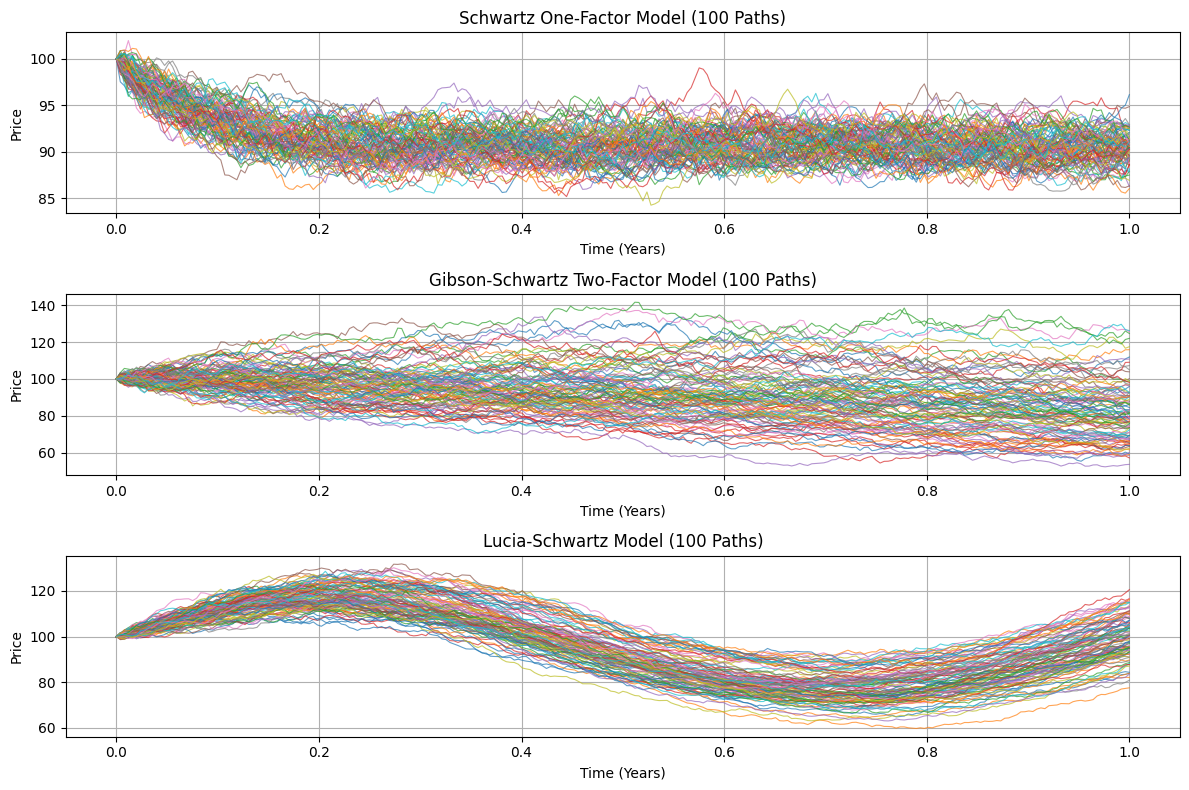

In [22]:
def main():
    np.random.seed(42)  # For reproducibility

    # Common simulation settings:
    T = 1.0            # 1 year
    n_steps = 252       # daily steps
    n_paths = 100
    times = np.linspace(0, T, n_steps + 1)
    S0 = 100.0
    r = 0.05            # risk-free rate used for discounting

    # -----------------------------
    # 1. Schwartz One-Factor Model
    # -----------------------------
    true_params_schwartz = {'kappa': 1.0, 'mu': 4.5, 'sigma': 0.2}
    model_schwartz_true = SchwartzOneFactor(
        S0=S0,
        kappa=true_params_schwartz['kappa'],
        mu=true_params_schwartz['mu'],
        sigma=true_params_schwartz['sigma'],
        T=T, n_steps=n_steps, r=r
    )
    observed_path = model_schwartz_true.simulate_paths(n_paths=1)
    observed_logS = np.log(observed_path[:, 0])

    schwartz_model = SchwartzOneFactor(
        S0=S0, kappa=0.5, mu=4.0, sigma=0.1,
        T=T, n_steps=n_steps, r=r
    )
    res1 = schwartz_model.calibrate(observed_logS, times)
    print("\nSchwartz One-Factor Calibration Results:", res1.x)

    # Simulate 100 paths and calculate the mean price at maturity
    paths_schwartz = schwartz_model.simulate_paths(n_paths=n_paths)
    price_schwartz = schwartz_model.calculate_price(paths_schwartz)
    print("Schwartz One-Factor Price (Mean of Paths):", price_schwartz)

    # -----------------------------
    # 2. Gibson-Schwartz Two-Factor Model
    # -----------------------------
    delta0 = 0.03
    true_params_gs = {
        'kappa': 0.8, 'alpha': 0.04,
        'sigma_delta': 0.1, 'sigma_S': 0.2, 'rho': 0.5
    }
    model_gs_true = GibsonSchwartz(
        S0=S0, delta0=delta0, r=r,
        sigma_S=true_params_gs['sigma_S'],
        sigma_delta=true_params_gs['sigma_delta'],
        kappa=true_params_gs['kappa'],
        alpha=true_params_gs['alpha'],
        rho=true_params_gs['rho'],
        T=T, n_steps=n_steps
    )
    gs_paths_true, _ = model_gs_true.simulate_paths(n_paths=1)
    observed_S_gs = gs_paths_true[:, 0]

    gs_model = GibsonSchwartz(
        S0=S0, delta0=delta0, r=r,
        sigma_S=true_params_gs['sigma_S'],
        sigma_delta=0.05,
        kappa=0.5, alpha=0.03, rho=0.5,
        T=T, n_steps=n_steps
    )
    res2 = gs_model.calibrate(observed_S_gs, times)
    print("\nGibson-Schwartz Calibration Results:", res2.x)

    # Simulate 100 paths and calculate the mean price at maturity
    paths_gs, _ = gs_model.simulate_paths(n_paths=n_paths)
    price_gs = gs_model.calculate_price(paths_gs)
    print("Gibson-Schwartz Price (Mean of Paths):", price_gs)

    # -----------------------------
    # 3. Lucia-Schwartz Model
    # -----------------------------
    true_season = (0.2, 0.0, 0.0, 4.5)
    true_params_lucia = {'kappa': 1.2, 'mu': 0.0, 'sigma': 0.15}
    model_lucia_true = LuciaSchwartz(
        S0=S0,
        kappa=true_params_lucia['kappa'],
        mu=true_params_lucia['mu'],
        sigma=true_params_lucia['sigma'],
        season_params=true_season,
        T=T, n_steps=n_steps, r=r
    )
    lucia_paths_true = model_lucia_true.simulate_paths(n_paths=1)
    observed_logS_lucia = np.log(lucia_paths_true[:, 0])

    lucia_model = LuciaSchwartz(
        S0=S0,
        kappa=0.8, mu=0.5, sigma=0.1,
        season_params=(0.1, 0.1, 0.0, 4.0),
        T=T, n_steps=n_steps, r=r
    )
    res3 = lucia_model.calibrate(observed_logS_lucia, times)
    print("\nLucia-Schwartz Calibration Results:", res3.x)

    # Simulate 100 paths and calculate the mean price at maturity
    paths_lucia = lucia_model.simulate_paths(n_paths=n_paths)
    price_lucia = lucia_model.calculate_price(paths_lucia)
    print("Lucia-Schwartz Price (Mean of Paths):", price_lucia)

    # -----------------------------
    # Comparative Analysis: Plot 100 Paths for each Model
    # -----------------------------
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(times, paths_schwartz, lw=0.8, alpha=0.7)
    plt.title("Schwartz One-Factor Model (100 Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Price")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(times, paths_gs, lw=0.8, alpha=0.7)
    plt.title("Gibson-Schwartz Two-Factor Model (100 Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Price")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(times, paths_lucia, lw=0.8, alpha=0.7)
    plt.title("Lucia-Schwartz Model (100 Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Price")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()